<a href="https://colab.research.google.com/github/jill-05/Sentimnet-Analysis-of-Amazon-Review/blob/main/NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis in Python


* VADER (Valence Aware Dictionary and sEntiment Reasoner) - Bag of words approach
* Roberta Pretrained Model from 🤗


### Step 0: Read in Data and NLTK Basics

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

plt.style.use('ggplot')

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
data = pd.read_csv('/content/Final/amazon.csv')

In [ ]:
data.head()

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
0,0,NaN,4,No issues.,23-07-2014,138,0,0,0,0,0.0,0.0
1,1,0mie,5,"Purchased this for my device, it worked as adv...",25-10-2013,409,0,0,0,0,0.0,0.0
2,2,1K3,4,it works as expected. I should have sprung for...,23-12-2012,715,0,0,0,0,0.0,0.0
3,3,1m2,5,This think has worked out great.Had a diff. br...,21-11-2013,382,0,0,0,0,0.0,0.0
4,4,2&amp;1/2Men,5,"Bought it with Retail Packaging, arrived legit...",13-07-2013,513,0,0,0,0,0.0,0.0


### Quick EDA

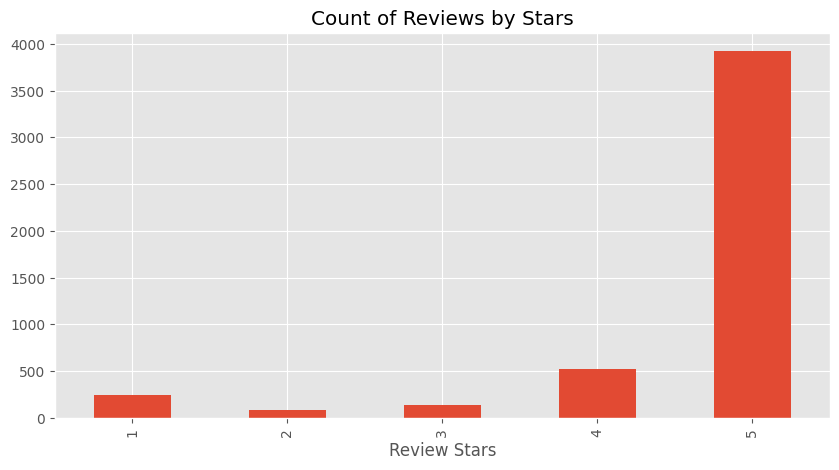

In [ ]:
ax = data['overall'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

### Basic NLTK

In [ ]:
example = data['reviewText'][50]
print(example)

A memory card either works or it doesn't. This was always going to be a one star or five star review - no middle ground.The adapter is a nice bonus too, though I don't think I have anything to use it with.


In [ ]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['A', 'memory', 'card', 'either', 'works', 'or', 'it', 'does', "n't", '.']

In [ ]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('A', 'DT'),
 ('memory', 'NN'),
 ('card', 'NN'),
 ('either', 'CC'),
 ('works', 'VBZ'),
 ('or', 'CC'),
 ('it', 'PRP'),
 ('does', 'VBZ'),
 ("n't", 'RB'),
 ('.', '.')]

In [ ]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  A/DT
  memory/NN
  card/NN
  either/CC
  works/VBZ
  or/CC
  it/PRP
  does/VBZ
  n't/RB
  ./.
  This/DT
  was/VBD
  always/RB
  going/VBG
  to/TO
  be/VB
  a/DT
  one/CD
  star/NN
  or/CC
  five/CD
  star/NN
  review/NN
  -/:
  no/DT
  middle/JJ
  ground.The/NN
  adapter/NN
  is/VBZ
  a/DT
  nice/JJ
  bonus/NN
  too/RB
  ,/,
  though/IN
  I/PRP
  do/VBP
  n't/RB
  think/VB
  I/PRP
  have/VBP
  anything/NN
  to/TO
  use/VB
  it/PRP
  with/IN
  ./.)


### Step 1. VADER Seniment Scoring

We will use NLTK's SentimentIntensityAnalyzer to get the neg/neu/pos scores of the text.

This uses a "bag of words" approach:
Stop words are removed
each word is scored and combined to a total score.

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [ ]:
sia.polarity_scores('I am so happy!')


{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [ ]:
sia.polarity_scores('This is the worst thing ever.')


{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [ ]:
sia.polarity_scores(example)

{'neg': 0.053, 'neu': 0.795, 'pos': 0.152, 'compound': 0.6249}

In [ ]:
#removing floating values
def remove_numeric(text):
    return re.sub(r'\b\d+\b', ' ', str(text))

data['reviewText'] = data['reviewText'].apply(remove_numeric)

In [ ]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(data.iterrows(), total=len(data)):
    text = row['reviewText']
    myid = row['Unnamed: 0']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/4915 [00:00<?, ?it/s]

In [ ]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Unnamed: 0'})
vaders = vaders.merge(data, how='left')

In [ ]:
# Now we have sentiment score and metadata
vaders.head()

,Unnamed: 0,neg,neu,pos,compound,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
0,0,0.688,0.312,0.000,-0.2960,NaN,4,No issues.,23-07-2014,138,0,0,0,0,0.0,0.0
1,1,0.075,0.925,0.000,-0.2960,0mie,5,"Purchased this for my device, it worked as adv...",25-10-2013,409,0,0,0,0,0.0,0.0
2,2,0.077,0.923,0.000,-0.3089,1K3,4,it works as expected. I should have sprung for...,23-12-2012,715,0,0,0,0,0.0,0.0
3,3,0.000,0.909,0.091,0.7081,1m2,5,This think has worked out great.Had a diff. br...,21-11-2013,382,0,0,0,0,0.0,0.0
4,4,0.040,0.828,0.132,0.7087,2&amp;1/2Men,5,"Bought it with Retail Packaging, arrived legit...",13-07-2013,513,0,0,0,0,0.0,0.0


### Plot VADER Results

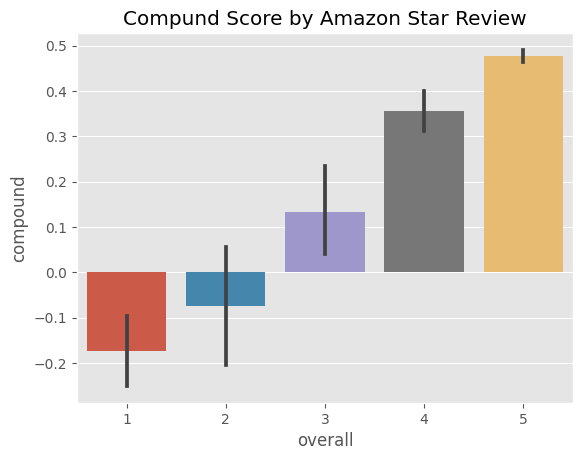

In [ ]:
ax = sns.barplot(data=vaders, x='overall', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

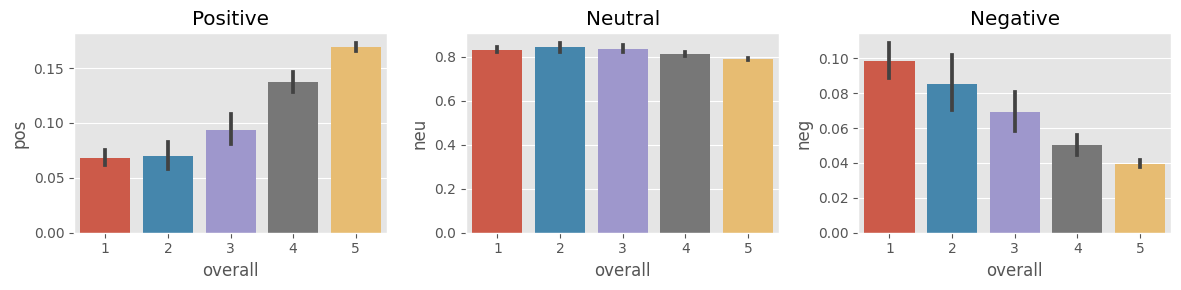

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='overall', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='overall', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='overall', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

### Step 3. Roberta Pretrained Model
Use a model trained of a large corpus of data.
Transformer model accounts for the words but also the context related to other words.

In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [ ]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
# VADER results on example
print(example)
sia.polarity_scores(example)

A memory card either works or it doesn't. This was always going to be a one star or five star review - no middle ground.The adapter is a nice bonus too, though I don't think I have anything to use it with.


{'neg': 0.053, 'neu': 0.795, 'pos': 0.152, 'compound': 0.6249}

In [ ]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.15133719, 'roberta_neu': 0.40594342, 'roberta_pos': 0.4427194}


In [ ]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [ ]:
res = {}
for i, row in tqdm(data.iterrows(), total=len(data)):
    try:
        text = row['reviewText']
        myid = row['Unnamed: 0']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/4915 [00:00<?, ?it/s]

Broke for id 76
Broke for id 123
Broke for id 722
Broke for id 1380
Broke for id 2031
Broke for id 2799
Broke for id 2881
Broke for id 2934
Broke for id 2993
Broke for id 3345
Broke for id 3449
Broke for id 3757
Broke for id 3967
Broke for id 4176
Broke for id 4212
Broke for id 4423
Broke for id 4587
Broke for id 4596


In [ ]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Unnamed: 0'})
results_df = results_df.merge(data, how='left')

### Compare Scores between models

In [ ]:
results_df.columns

Index(['Unnamed: 0', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'reviewerName', 'overall',
       'reviewText', 'reviewTime', 'day_diff', 'helpful_yes', 'helpful_no',
       'total_vote', 'score_pos_neg_diff', 'score_average_rating',
       'wilson_lower_bound'],
      dtype='object')

### Step 3. Combine and compare

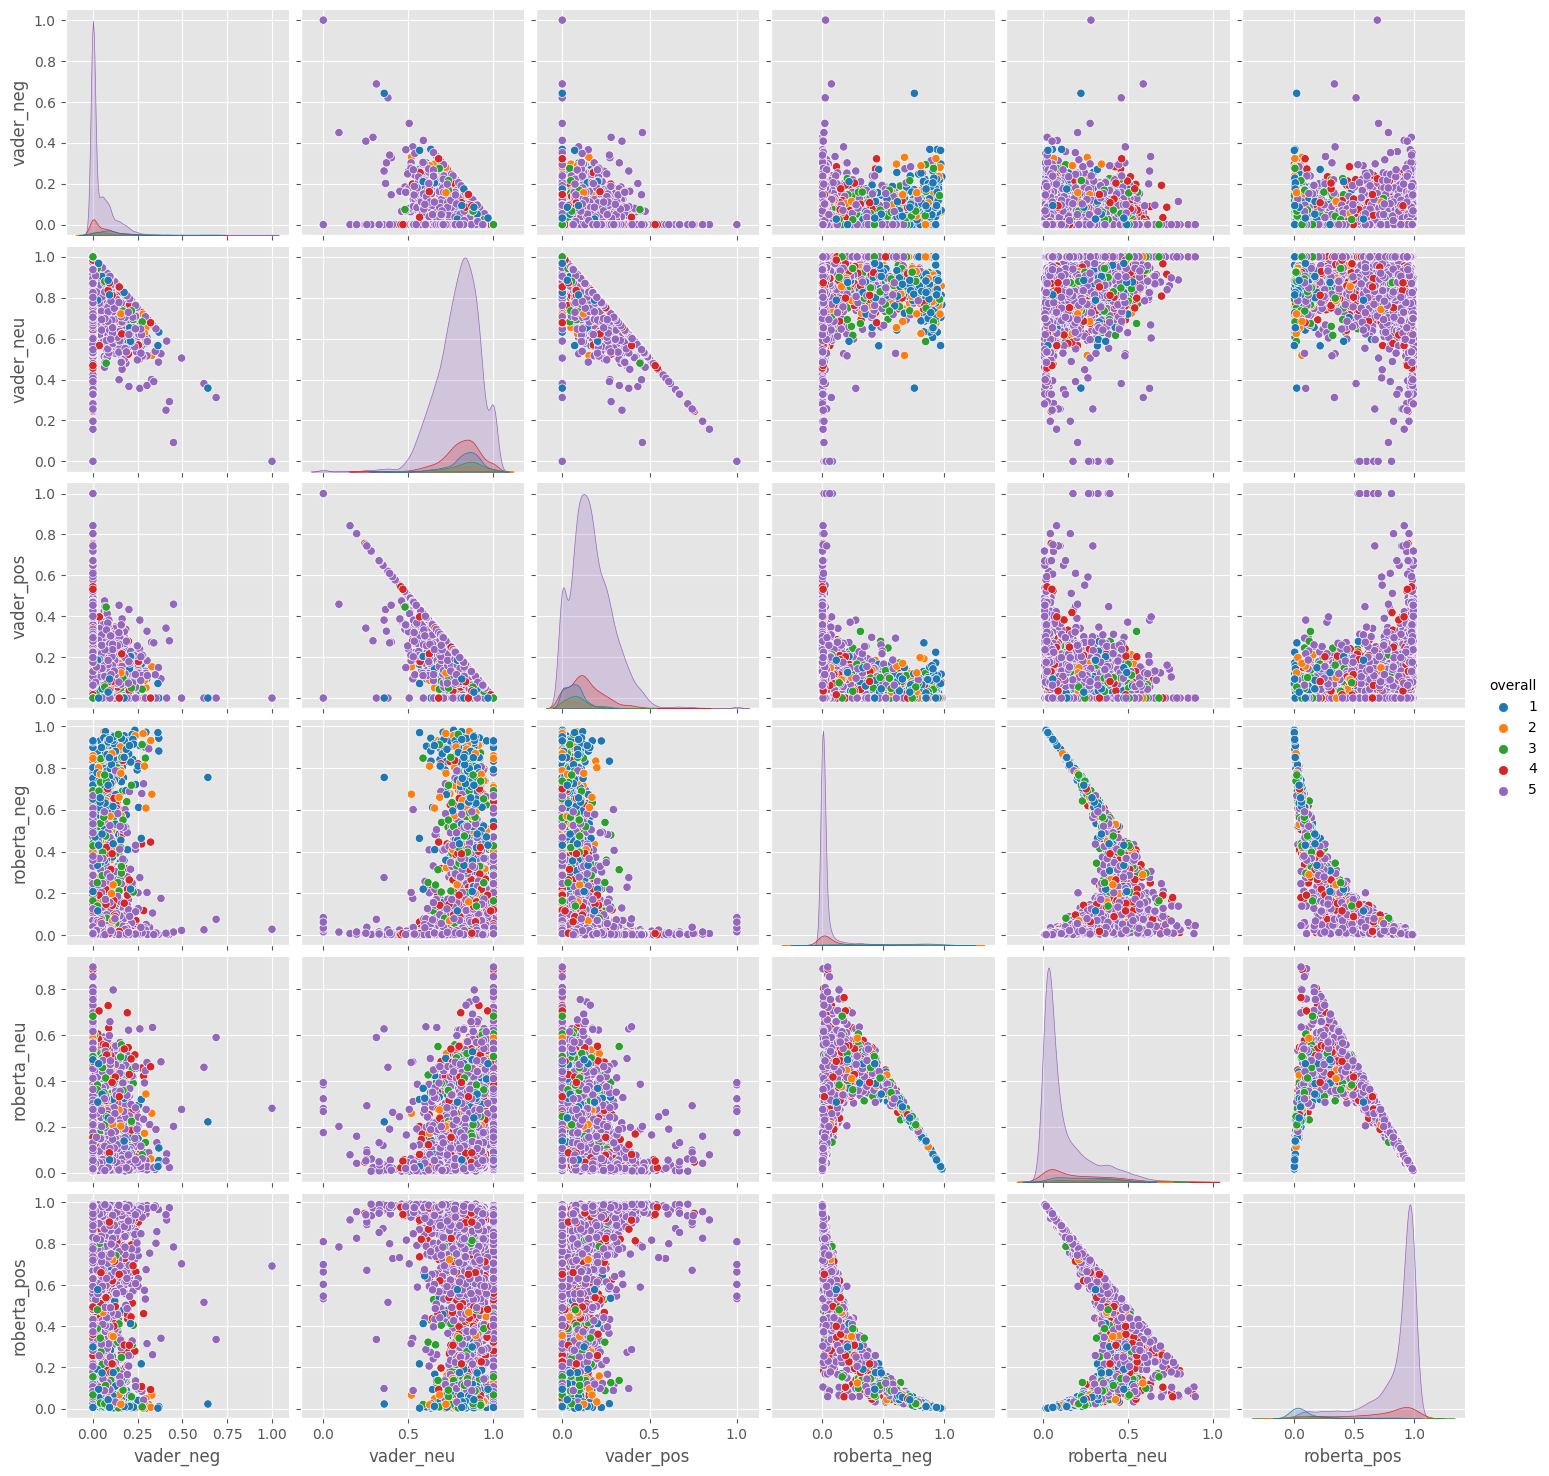

In [ ]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='overall',
            palette='tab10')
plt.show()

### Step 4: Review Examples
Positive 1-Star and Negative 5-Star Reviews

In [ ]:
results_df.query('overall == 1') \
    .sort_values('roberta_pos', ascending=False)['reviewText'].values[0]

'I returned to order a  .  laptop so I could have full operations than having a Notebook. I am sure this is good quality as I have purchased San Disk numerous times.'

In [ ]:
results_df.query('overall == 1') \
    .sort_values('vader_pos', ascending=False)['reviewText'].values[0]

'The card only read as   GB not   GB. I have formatted in various formats with various tools, and operating systems. I ordered a replacement and concluded this was a dud. Good luck buying this product, rest assured amazon has a good return policy.'

In [ ]:
# nevative sentiment 5-Star view
results_df.query('overall == 5') \
    .sort_values('roberta_neg', ascending=False)['reviewText'].values[0]

"I only buy thru Amazon I've tried eBay and you always come thru and I got messed over four times and no real recourse you just lose and PayPal is nobodies pal. And these no more rack are terrible and all these others take my advise stick with the one that has always came thru every time for me. Amazon and only Amazon . H.Rhodes"

In [ ]:
results_df.query('overall == 5') \
    .sort_values('vader_neg', ascending=False)['reviewText'].values[0]

'No problems!'